## 1. Create a Delivery Stream to S3 using Kinesis

O primeiro passo é coletar dados. Dados podem ser gerados em streaming por diversas fontes, como sensores de IoT (Internet das Coisas), aplicativos móveis, logs de servidores, feeds de mídia social, transações financeiras, entre outros. Esses dados são transmitidos em tempo real, geralmente em pequenos pacotes chamados eventos. Para lidar com o streaming de dados, são utilizadas tecnologias e plataformas específicas, como a Kinesis da AWS, Apache Kafka, Apache Flink, Apache Spark Streaming, entre outras. Essas ferramentas oferecem recursos para a ingestão, processamento, armazenamento e análise de dados em streaming, tornando possível lidar com grandes volumes de dados em tempo real de maneira escalável e eficiente.

Nesse tutorial usaremos o Kinesis,  um serviço da AWS que permite o processamento e a análise de dados em tempo real em grande escala. Basicamente, existem três serviços principais dentro do Kinesis: o Amazon Kinesis Data Streams, o Amazon Kinesis Data Firehose e o Amazon Kinesis Data Analytics.

Amazon Kinesis Data Streams: É a parte central do serviço Kinesis. Ele permite a ingestão de grandes volumes de dados em tempo real e a capacidade de processá-los em tempo hábil. Os dados são divididos em shards (partições) que podem ser lidos e gravados simultaneamente. Os aplicativos podem consumir os dados diretamente dos streams do Kinesis ou processá-los usando o Amazon Kinesis Data Analytics ou qualquer outra ferramenta de processamento de dados em tempo real.

Amazon Kinesis Data Firehose: É um serviço que permite a ingestão direta de dados em vários destinos de armazenamento, como Amazon S3, Amazon Redshift, Amazon Elasticsearch Service e Amazon Splunk. O Kinesis Data Firehose gerencia automaticamente o dimensionamento e a entrega dos dados para os destinos especificados, aliviando a carga de trabalho do desenvolvedor.

Amazon Kinesis Data Analytics: É uma ferramenta que permite a análise em tempo real de dados em streaming usando consultas SQL padrão. Você pode executar consultas em tempo real para filtrar, transformar e agregar dados, gerando insights imediatos. O Kinesis Data Analytics permite criar aplicativos de análise avançada e aplicar aprendizado de máquina a dados em streaming.

Podemos simular um serviço de entrega de dados em tempo real usando kinesis. Para isso vamos escolher a base dados da amazon que contém reviews de video games. 

In [19]:
import boto3
import json
import pandas as pd
import time
import uuid
import matplotlib.pyplot as plt


# Specify the name of the Kinesis Data Stream
stream_name = 'video_games_review_amazon'

# Create a Kinesis client
session = boto3.Session(profile_name='bruno_personal')
kinesis_client = session.client("kinesis")

In [20]:
#load the dataset
books_df = pd.read_json('http://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Video_Games_5.json.gz', lines = True)

In [21]:
books_df['reviewText']

0         This game is a bit hard to get the hang of, bu...
1         I played it a while but it was alright. The st...
2                                                  ok game.
3         found the game a bit too complicated, not what...
4         great game, I love it and have played it since...
                                ...                        
497572                   not OEM but good replacement parts
497573                                          Okay stuff.
497574    This does add some kids room things that are v...
497575    I think I originally began playing Bioshock se...
497576    The graphics are terrible, it looks like ps2 g...
Name: reviewText, Length: 497577, dtype: object

In [22]:
print(f'Number of users: {books_df.reviewerID.nunique()}')
print(f'Number of itens: {books_df.asin.nunique()}')

Number of users: 55223
Number of itens: 17408


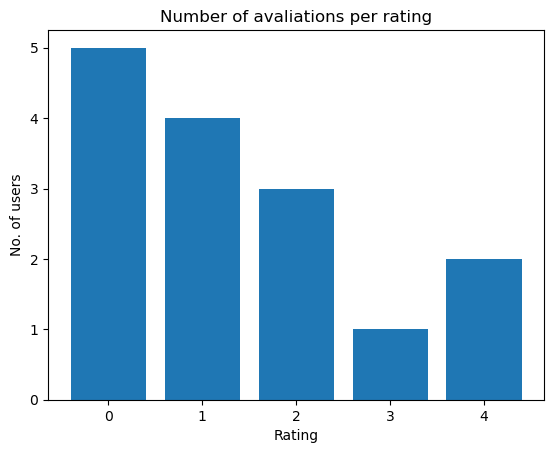

In [23]:
d = (books_df.overall.value_counts().reset_index())
plt.bar(d.index, d.overall);
plt.xlabel("Rating")
plt.ylabel("No. of users")
plt.title("Number of avaliations per rating")
plt.show()

Faremos o seguinte: Usaremos o kinesis Data Stream para criar um fluxo de dados; depois usaremos o Kinesis Firehose para enviar os dados para a Source Zone do Datalake, localizado em um bucket que criaremos no S3. Uma função lambda pode ser usada para transformar os dados de entrada para o formato parquet.

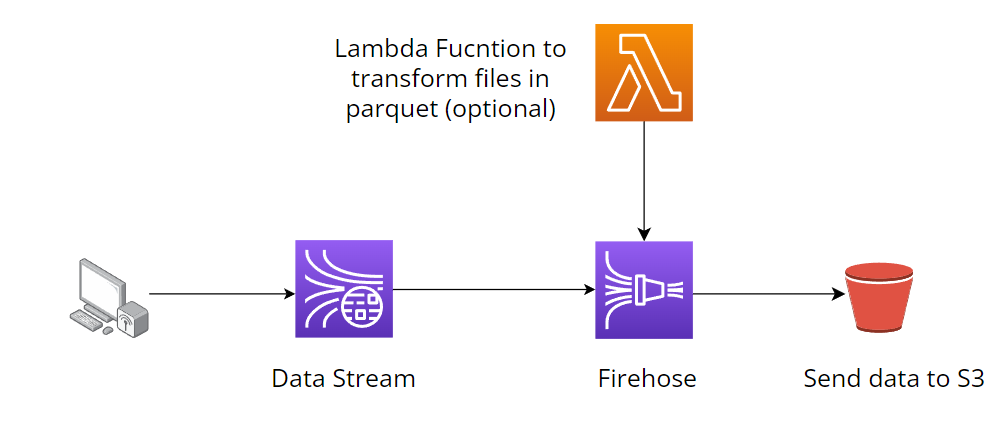

### Amazon Kinesis Data Streams

Vamos primeiro criar um fluxo de dados. Configure o stream: Forneça um nome para o seu stream de dados e defina o número de shards (partições) desejado. Os shards determinam a capacidade e o desempenho do stream. Mais shards permitem um maior volume de dados, mas também aumentam os custos. Considere cuidadosamente as necessidades do seu caso de uso ao determinar o número de shards. Também é importante configurar a retenção de dados, que determina por quanto tempo os dados no stream serão armazenados antes de serem excluídos automaticamente. Você pode optar por reter os dados por até 7 dias. 

Usaremos o boto para criar um fluxo de dados. Por padrão, vamos escolher 1 shard e um período de retenção de um dia (default). 1 shard é capaz de escrever 1 Mib ou 1000 records por segundo e ler 2 Mib por segundo. 

In [25]:
shard_count = 1
response = kinesis_client.create_stream(
    StreamName=stream_name,
    ShardCount=shard_count
)

ResourceInUseException: An error occurred (ResourceInUseException) when calling the CreateStream operation: Stream video_games_review_amazon under account 324430962407 already exists.

In [26]:
response = kinesis_client.describe_stream(StreamName=stream_name)
stream_status = response['StreamDescription']['StreamStatus']
print("Stream status:", stream_status)

Stream status: ACTIVE


### Amazon Kinesis Data Firehose

Vamos agora criar um delivery stream que envia os dados para um bucket do S3. O bucket de entrega é onde está localizado o nosso datalake. Em particular criei um chamado bbs-datalake.
Abra o serviço Kinesis Data Firehose: No painel do Kinesis, clique em "Create delivery stream" (Criar delivery stream) no Amazon Kinesis Data Firehose. Configure o delivery stream:
a. Selecione a origem dos dados, que será o stream de dados que você criou anteriormente no Amazon Kinesis Data Streams.
b. Selecione "Amazon S3" como o destino.
c. Clique em "Create new" para criar um novo bucket do Amazon S3 ou selecione um bucket existente.
d. Escolha um nome para o seu delivery stream.
e. adicione um prefixo no bucket

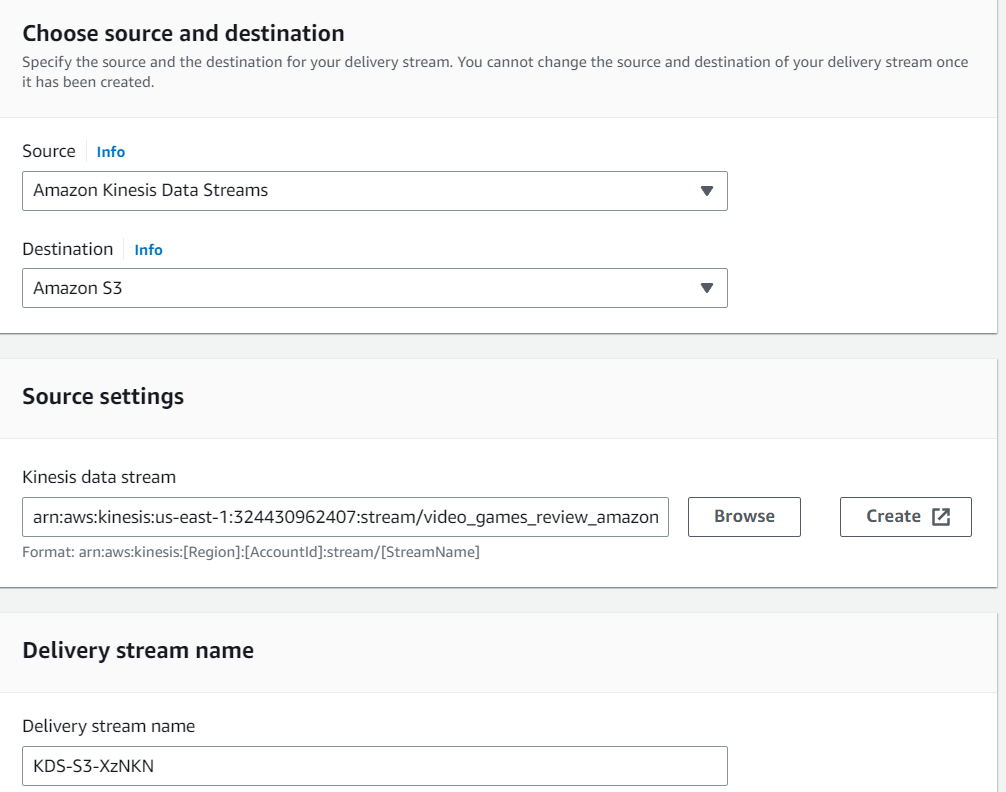

No bucket que contém o datalake, os dados brutos são entregues na Source Zone (ou Bronze Data). Crie um prefixo para localizarmos a tabela video_games_review_amazon na Source Zone do datalake.

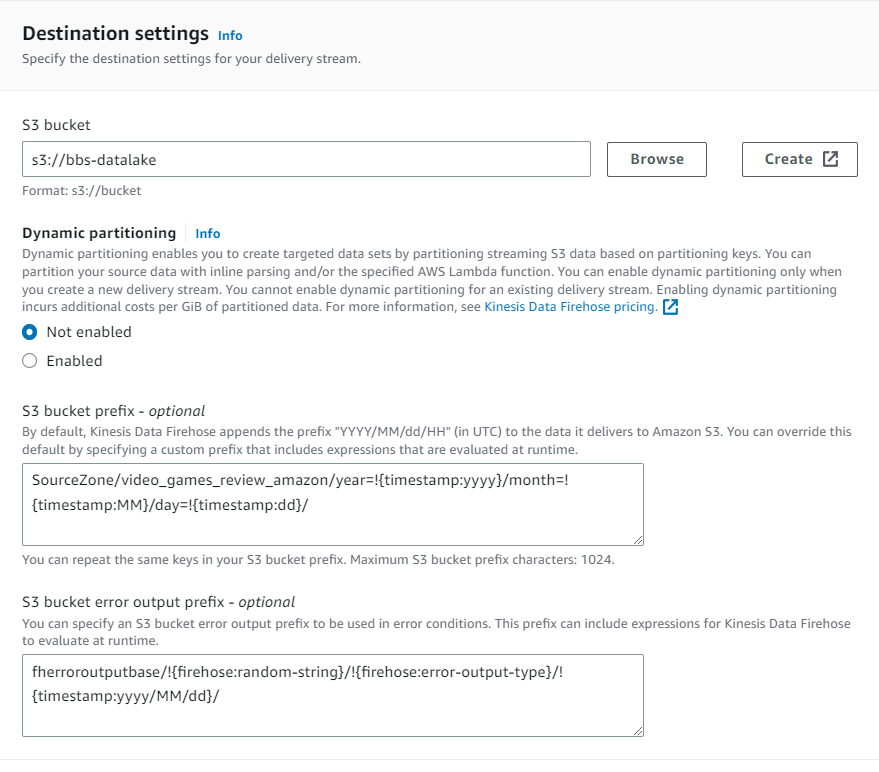

Em ***Buffer hints, compression and encryption***, altere somente o buffer interval para o mínimo, 60 segundos.
É possível configurar as opções de transformação (opcional): Se desejar transformar ou formatar os dados antes de enviá-los para o bucket do S3, você pode adicionar transformações usando o AWS Lambda. Queremos que os dados chegem na Source Zone sem nenhum tipo de transformação, portanto iremos entregá-lo diretamente ao s3 sem nenhuma etapa adicional. Aconselho apenas a comprimir os dados (gzip é mais eficaz) de maneira a economizar espaço em disco. Lembrando que também seria possível Configurar as opções de processamento adicional, caso você precise processar os dados usando serviços como o Amazon Elasticsearch Service ou o Amazon Redshift.

Sobre o produtor dos dados, o kinesis possui três producers:
 - ***SDK*** :  é uma coleção de bibliotecas e ferramentas disponíveis em várias linguagens de programação, como Java, Python, .NET, entre outras. O SDK permite que você desenvolva aplicativos personalizados para produzir e consumir dados do Amazon Kinesis. Ele oferece APIs de alto nível, usando PutRecord (one) ou PutRecords (muitos), que facilitam o envio de registros para o Kinesis Streams ou Kinesis Data Firehose, gerenciando automaticamente detalhes de autenticação e conexão. É dorecionado para aplicações mais simples, que não exigem baixa latência ou alta transferência.

 - ***Kinesis Producer Library (KPL)***: O Kinesis Producer Library é uma biblioteca de alto desempenho feita para facilitar o envio eficiente de grandes volumes de dados para o Amazon Kinesis Streams. O KPL é projetado para lidar com o particionamento e a agregação de registros, bem como para lidar com casos de uso de streaming de alto rendimento. Ele também fornece mecanismos de buffering e reenvio automático em caso de falhas temporárias de conectividade.

 - ***Kinesis Agent***: O Kinesis Agent é uma ferramenta de linha de comando feita para facilitar o envio contínuo de logs e arquivos para o Amazon Kinesis Data Streams ou Kinesis Data Firehose. Ele é especialmente útil para o envio de dados de log de servidores ou aplicativos diretamente para o Kinesis. O Kinesis Agent monitora os arquivos de log especificados ou diretórios e envia os dados para o Kinesis em tempo real, cuidando de aspectos como o particionamento dos registros e a configuração de streaming.

Aqui vamos simular um streaming usando como produtor o Kinesis SDK a partir do boto3. Basicamente enviaremos 100 linhas de nossa base por segundo para o Data Stream que criamos. Cada pacote de dados é um json com 100 linhas.

In [28]:
import json
import time
import pandas as pd
import uuid
# Split the DataFrame into chunks of 50 rows each
chunk_size = 100
df_chunks = [books_df[i:i+chunk_size] for i in range(0, books_df.shape[0], chunk_size)]

# Process and send each chunk
i=0
partition_key = str(uuid.uuid4())
for chunk in df_chunks:
    records = []
    print(f'entrega {i}')
    for _, record in chunk.iterrows():
        #converto as colunas que contém dicionários em string, para conseguir exibí-las no athena.
        record['style'] = str(record['style'])
        record['image'] = str(record['image'])
        data = json.dumps(record.to_dict())
        records.append({'Data': data, 'PartitionKey': partition_key})

    # Send records to Kinesis
    kinesis_client.put_records(StreamName=stream_name, Records=records)

    # Wait for 1 second before sending the next chunk
    time.sleep(1)
    i+=1

entrega 0
entrega 1
entrega 2
entrega 3
entrega 4
entrega 5
entrega 6
entrega 7
entrega 8
entrega 9
entrega 10
entrega 11
entrega 12
entrega 13
entrega 14
entrega 15
entrega 16
entrega 17
entrega 18
entrega 19
entrega 20
entrega 21
entrega 22
entrega 23
entrega 24
entrega 25
entrega 26
entrega 27
entrega 28
entrega 29
entrega 30
entrega 31
entrega 32
entrega 33
entrega 34
entrega 35
entrega 36
entrega 37
entrega 38
entrega 39
entrega 40
entrega 41
entrega 42
entrega 43
entrega 44
entrega 45
entrega 46
entrega 47
entrega 48
entrega 49
entrega 50
entrega 51
entrega 52
entrega 53
entrega 54
entrega 55
entrega 56
entrega 57
entrega 58
entrega 59
entrega 60
entrega 61
entrega 62
entrega 63
entrega 64
entrega 65
entrega 66
entrega 67
entrega 68
entrega 69
entrega 70
entrega 71
entrega 72
entrega 73
entrega 74
entrega 75
entrega 76
entrega 77
entrega 78
entrega 79
entrega 80
entrega 81
entrega 82
entrega 83
entrega 84
entrega 85
entrega 86
entrega 87
entrega 88
entrega 89
entrega 90
entrega 9

KeyboardInterrupt: 

In [ ]:
data

Caso tudo tenha dado certo. Após alguns minutos já podemos ver arquivos chegando no S3. Cada arquivo contém 5MB (o buffer size recomendado do Firehose).

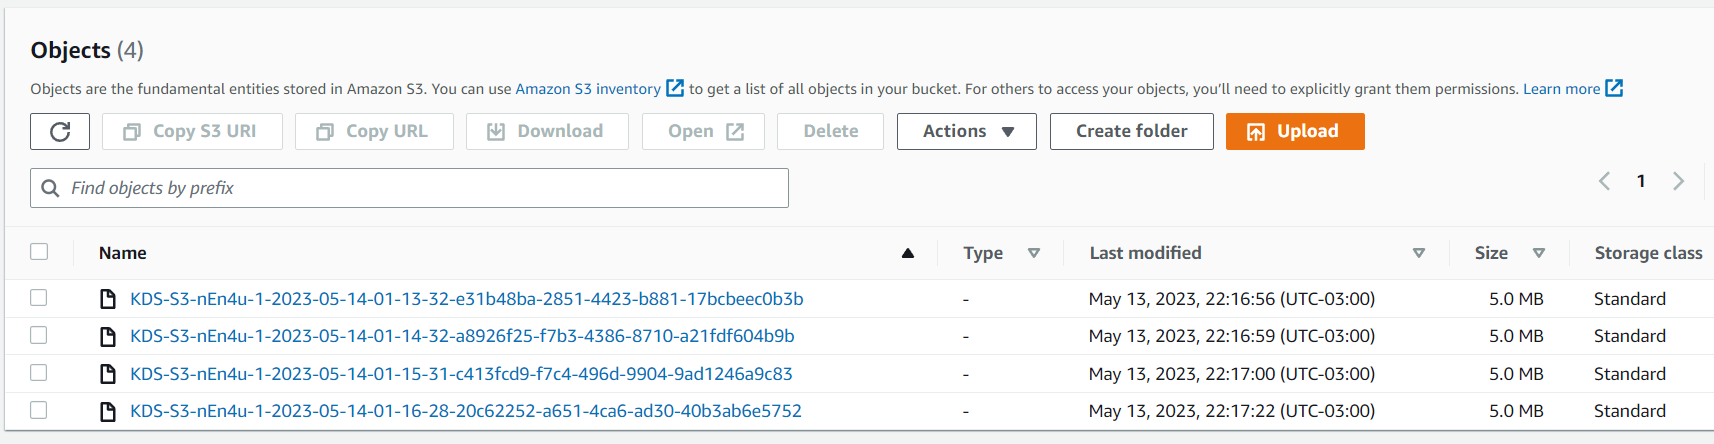

Legal! Agora temos dados chegando na Source Zone do datalake. No próximo tutorial falaremos sobre a estrutura do datalake e que são cada uma das zonas de dados. Também falaremos sobre o Glue e o Lake Formation.